In [1]:
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [2]:
# !pip install -q git+https://github.com/matjesg/deepflash2.git

In [3]:
# !pip install zarr

In [4]:
# !git clone https://github.com/JunMa11/SegLoss

In [5]:
# imports
import zarr, cv2
import numpy as np, pandas as pd, segmentation_models_pytorch as smp
from deepflash2.all import *
from deepflash2.transforms import random_center
import albumentations as alb
import torch
import torch.nn as nn

In [6]:
import sys
sys.path.insert(0, "./SegLoss/losses_pytorch")

In [7]:
from config.global_vars import *

In [8]:
ARCH = 'pan'

In [9]:
# Model
model = smp.PAN(encoder_name=ENCODER_NAME, 
                 encoder_weights=ENCODER_WEIGHTS, 
                 in_channels=CHANNELS, 
                 classes=CLASSES)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)
model.cuda();

Let's use 2 GPUs!


In [10]:
from fastai.vision.all import *

In [11]:
@patch
def read_img(self:BaseDataset, file, *args, **kwargs):
    return zarr.open(str(file), mode='r')

@patch
def _name_fn(self:BaseDataset, g):
    "Name of preprocessed and compressed data."
    return f'{g}'

@patch
def apply(self:DeformationField, data, offset=(0, 0), pad=(0, 0), order=1):
    "Apply deformation field to image using interpolation"
    outshape = tuple(int(s - p) for (s, p) in zip(self.shape, pad))
    coords = [np.squeeze(d).astype('float32').reshape(*outshape) for d in self.get(offset, pad)]
    # Get slices to avoid loading all data (.zarr files)
    sl = []
    for i in range(len(coords)):
        cmin, cmax = int(coords[i].min()), int(coords[i].max())
        dmax = data.shape[i]
        if cmin<0: 
            cmax = max(-cmin, cmax)
            cmin = 0 
        elif cmax>dmax:
            cmin = min(cmin, 2*dmax-cmax)
            cmax = dmax
            coords[i] -= cmin
        else: coords[i] -= cmin
        sl.append(slice(cmin, cmax))    
    if len(data.shape) == len(self.shape) + 1:
        tile = np.empty((*outshape, data.shape[-1]))
        for c in range(data.shape[-1]):
            # Adding divide
            tile[..., c] = cv2.remap(data[sl[0],sl[1], c]/255, coords[1],coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    else:
        tile = cv2.remap(data[sl[0], sl[1]], coords[1], coords[0], interpolation=order, borderMode=cv2.BORDER_REFLECT)
    return tile

In [12]:
@patch
def __getitem__(self:RandomTileDataset, idx):
    idx = idx % len(self.files)
    if torch.is_tensor(idx):
        idx = idx.tolist()

    img_path = self.files[idx]
    img = self.read_img(img_path, divide=self.divide)
    n_channels = img.shape[-1]

    lbl, pdf  = self.labels[img_path.name], self.pdfs[self._name_fn(img_path.name)]
    center = random_center(pdf[:], lbl.shape, TILE_SHAPE)
    X = self.gammaFcn(self.deformationField.apply(img, center).flatten()).reshape((*self.tile_shape, n_channels))
    Y = self.deformationField.apply(lbl, center, self.padding, 0)
    X1 = X.copy()

    if self.albumentations_tfms:
        augmented = self.albumentations_tfms(image=(X*255).astype('uint8'),mask=Y.astype('uint8'))
        X = (augmented['image']/255)
        Y = augmented['mask']

    X = X.transpose(2, 0, 1).astype('float32')
    Y = Y.astype('int64')

    if self.loss_weights:
        _, W = cv2.connectedComponents((Y > 0).astype('uint8'), connectivity=4)
        return  TensorImage(X), TensorMask(Y), torch.Tensor(W)
    else:
        return  TensorImage(X), TensorMask(Y)

In [13]:
@patch
def _do_one_batch(self:Learner):
    self.pred = self.model(*self.xb)
    self('after_pred')
    if len(self.yb):
        self.loss_grad = self.loss_func(self.pred, *self.yb)
        self.loss = self.loss_grad.clone()
    self('after_loss')
    if not self.training or not len(self.yb): return
    self('before_backward')
    self.loss_grad.backward()
    self._with_events(self.opt.step, 'step', CancelStepException)
    self.opt.zero_grad()

### Metrics

In [14]:
def calc_intersection_cardinality(y_pred, y, dims=(-2, -1)):
    x = y_pred
    x = torch.argmax(x, 1)
    intersection = (x * y).to(torch.int8).sum(dims)
    cardinality = (x + y).to(torch.int8).sum(dims)
    return intersection, cardinality

def dice_metric(y_pred, y, epsilon = 1e-7, dims=(-2, -1)):
    intersection, cardinality = calc_intersection_cardinality(y_pred, y)
    dc = (2 * intersection + epsilon) / (cardinality + epsilon)
    return dc.mean()

def iou_metric(y_pred, y, epsilon = 1e-7, dims=(-2, -1)):
    intersection, cardinality = calc_intersection_cardinality(y_pred, y)
    dc = (intersection + epsilon) / (cardinality - intersection + epsilon)
    return dc.mean()

### Configuration

In [15]:
class CONFIG():
    
    # data paths
    data_path = Path('/home/jupyter/data_2/')
    data_path_zarr = Path('/home/jupyter/train_scale2')
    mask_preproc_dir = '/home/jupyter/masks_scale2'
    
    # deepflash2 dataset
    # scale = 1.5 # data is already downscaled to 2, so absulute downscale is 3
    scale = 1 # data is already downscaled to 2, so absulute downscale is 3
    tile_shape = (TILE_SHAPE, TILE_SHAPE)
    padding = (0,0) # Border overlap for prediction
    n_jobs = NUM_WORKERS
    sample_mult = 200 # Sample 100 tiles from each image, per epoch
    val_length = 500 # Randomly sample 500 validation tiles
    stats = np.array([0.61561477, 0.5179343 , 0.64067212]), np.array([0.2915353 , 0.31549066, 0.28647661])
    
    # deepflash2 augmentation options
    zoom_sigma = 0.1
    flip = True
    max_rotation = 360
    deformation_grid_size = (150,150)
    deformation_magnitude = (10,10)

    # pytorch model (segmentation_models_pytorch)
    encoder_name = ENCODER_NAME
    encoder_weights = ENCODER_WEIGHTS
    in_channels = 3
    classes = 2
    
    # fastai Learner 
    mixed_precision_training = True
    batch_size = 8
    weight_decay = 0.01
    loss_func = CrossEntropyLossFlat(axis=1)
    metrics = [Iou(), Dice_f1(), dice_metric, iou_metric]
    optimizer = ranger
    max_learning_rate = 5e-4
    epochs = 30
    
cfg = CONFIG()

In [16]:
# Albumentations augmentations
# Inspired by https://www.kaggle.com/iafoss/hubmap-pytorch-fast-ai-starter
# deepflash2 augmentations are only affine transformations
tfms = alb.Compose([
    alb.OneOf([
        alb.HueSaturationValue(10,15,10),
        alb.CLAHE(clip_limit=2),
        alb.RandomBrightness(limit=.2, p=1), 
        alb.RandomContrast(limit=.2, p=1), 
        alb.RandomGamma(p=1)
    ], p=.5)
], p=0.5)

In [17]:
df_train = pd.read_csv(cfg.data_path/'train.csv')
df_info = pd.read_csv(cfg.data_path/'HuBMAP-20-dataset_information.csv')

files = [x for x in cfg.data_path_zarr.iterdir() if x.is_dir() if not x.name.startswith('.')]
label_fn = lambda o: o

In [18]:
!ls {cfg.mask_preproc_dir}

labels	pdfs


### Training

In [19]:
# Datasets
ds_kwargs = {
    'tile_shape':cfg.tile_shape,
    'padding':cfg.padding,
    'scale': cfg.scale,
    'n_jobs': cfg.n_jobs, 
    'preproc_dir': cfg.mask_preproc_dir, 
    'val_length':cfg.val_length, 
    'sample_mult':cfg.sample_mult,
    'loss_weights':False,
    'zoom_sigma': cfg.zoom_sigma,
    'flip' : cfg.flip,
    'max_rotation': cfg.max_rotation,
    'deformation_grid_size' : cfg.deformation_grid_size,
    'deformation_magnitude' : cfg.deformation_magnitude,
    'albumentations_tfms': tfms
}

train_ds = RandomTileDataset(files, label_fn=label_fn, **ds_kwargs)
valid_ds = TileDataset(files, label_fn=label_fn, **ds_kwargs, is_zarr=True)

Using preprocessed masks from /home/jupyter/masks_scale2
Using preprocessed masks from /home/jupyter/masks_scale2


In [20]:
image, mask = train_ds[0]

In [21]:
image.shape, mask.shape

(torch.Size([3, 800, 800]), torch.Size([800, 800]))

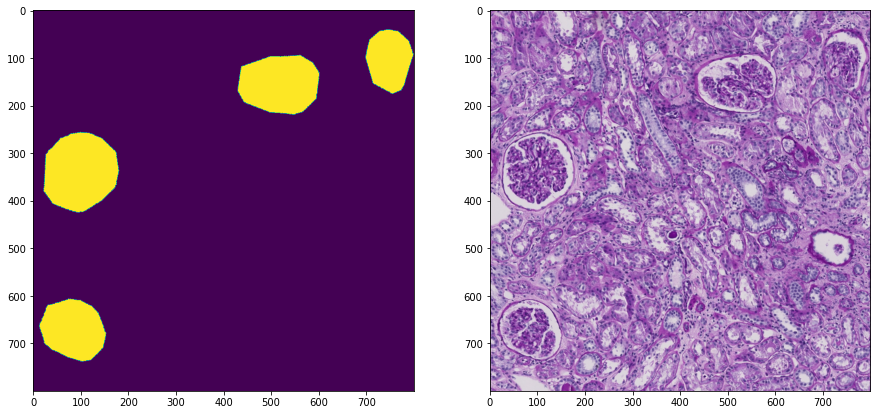

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(15,15))
resize_w = 250
resize = 250
ax[0].imshow(mask.cpu().numpy())
ax[1].imshow(np.moveaxis(image.cpu().numpy(), 0, -1))

In [23]:
from SegLoss.losses_pytorch.dice_loss import IoULoss
from SegLoss.losses_pytorch.dice_loss import SoftDiceLoss
from SegLoss.losses_pytorch.dice_loss import SSLoss
from SegLoss.losses_pytorch.dice_loss import TverskyLoss
from SegLoss.losses_pytorch.dice_loss import get_tp_fp_fn

In [24]:
dice_loss = load_kornia_loss('DiceLoss')
iou_loss = IoULoss(apply_nonlin=F.softmax, smooth=1.)
soft_dice_loss = SoftDiceLoss(apply_nonlin=F.softmax, smooth=1.)
ss_loss = SSLoss(apply_nonlin=F.softmax)
tversky_loss = TverskyLoss(apply_nonlin=F.softmax)

In [25]:
a = torch.randn([6, 2, 512, 512])
b = (torch.rand([6, 512, 512]) > 0.5).long()
1 + soft_dice_loss(a, b), dice_loss(a, b), 1 + tversky_loss(a, b), ss_loss(a, b), 1 + iou_loss(a, b)

/home/hubmap_notebooks/pdf_notebooks/SegLoss/losses_pytorch/dice_loss.py:278: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.apply_nonlin(x)
/home/hubmap_notebooks/pdf_notebooks/SegLoss/losses_pytorch/dice_loss.py:358: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.apply_nonlin(x)
/home/hubmap_notebooks/pdf_notebooks/SegLoss/losses_pytorch/dice_loss.py:234: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  net_output = self.apply_nonlin(net_output)
/home/hubmap_notebooks/pdf_notebooks/SegLoss/losses_pytorch/dice_loss.py:317: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.apply_nonlin(x)


(tensor(0.5000),
 tensor(0.5000),
 tensor(0.5000),
 tensor(0.3184),
 tensor(0.6667))

In [26]:
FACTORS = [0.3, 0.7]

cross_entropy = CrossEntropyLossFlat(axis=1)

def combined_loss(y_pred, y):
    return FACTORS[0] * cross_entropy(y_pred, y) + FACTORS[1] * (dice_loss(y_pred, y))

In [27]:
# Dataloader and learner
dls = DataLoaders.from_dsets(train_ds, valid_ds, bs=cfg.batch_size, after_batch=Normalize.from_stats(*cfg.stats))
if torch.cuda.is_available(): dls.cuda(), model.cuda()
cbs = [SaveModelCallback(monitor='dice_metric'), ElasticDeformCallback, GradientClip(max_norm=1.0)]
learn = Learner(dls, model, metrics=cfg.metrics, wd=cfg.weight_decay, loss_func=combined_loss, opt_func=ranger, cbs=cbs)
if cfg.mixed_precision_training: learn.to_fp16()

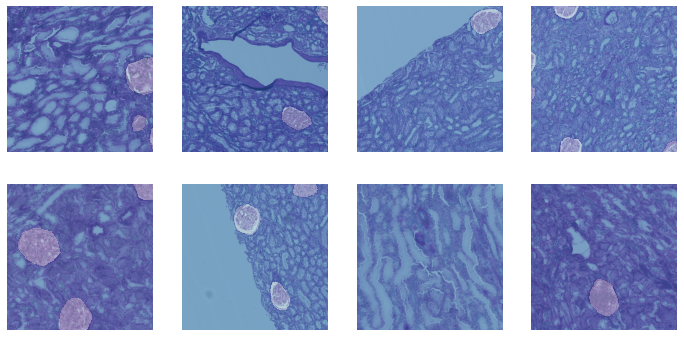

In [28]:
sample_batch = dls.show_batch()

In [29]:
# sample_image, _ = next(iter(dls.loaders[0]))
# sample_image.shape

In [30]:
# Fit
learn.fit_one_cycle(cfg.epochs, lr_max=cfg.max_learning_rate)
learn.recorder.plot_metrics()

epoch,train_loss,valid_loss,iou,dice_f1,dice_metric,iou_metric,time
0,0.158487,0.060218,0.272715,0.428557,0.119252,0.085408,09:29
1,0.027196,0.009637,0.765121,0.866933,0.803872,0.777931,09:13
2,0.014666,0.005595,0.835479,0.910366,0.841701,0.821814,09:09
3,0.012447,0.004737,0.867285,0.928926,0.912416,0.896677,09:09
4,0.011645,0.004976,0.853983,0.921242,0.877022,0.861911,09:08
5,0.010597,0.004018,0.878148,0.935121,0.943778,0.929617,09:09
6,0.010635,0.004994,0.865707,0.928020,0.883794,0.867680,09:08
7,0.009230,0.003647,0.885225,0.939118,0.952369,0.938114,09:08
8,0.009423,0.003668,0.883193,0.937974,0.943687,0.929965,09:09
9,0.008847,0.003376,0.887583,0.940444,0.952044,0.938500,09:09


Better model found at epoch 0 with dice_metric value: 0.11925175786018372.
Better model found at epoch 1 with dice_metric value: 0.8038723468780518.
Better model found at epoch 2 with dice_metric value: 0.8417014479637146.
Better model found at epoch 3 with dice_metric value: 0.9124158620834351.
Better model found at epoch 5 with dice_metric value: 0.943777859210968.
Better model found at epoch 7 with dice_metric value: 0.9523693323135376.
Better model found at epoch 10 with dice_metric value: 0.9619966149330139.
Better model found at epoch 16 with dice_metric value: 0.9624717235565186.
Better model found at epoch 17 with dice_metric value: 0.9638239145278931.
Better model found at epoch 20 with dice_metric value: 0.9693693518638611.


KeyboardInterrupt: 

In [31]:
!mv models/model.pth models/hubmap_pdf_sample_dice_ce_loss_{TILE_SHAPE}_{ARCH}_{ENCODER_NAME}_b{cfg.batch_size}.pth

In [ ]:
!echo models/hubmap_pdf_sample_dice_ce_loss_{TILE_SHAPE}_{ARCH}_{ENCODER_NAME}_b{cfg.batch_size}.pth